# **Importing Libraries**

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import re
import string
import nltk
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize

!pip --quiet install -U sentence-transformers
from sentence_transformers import SentenceTransformer,CrossEncoder
import pandas as pd

!pip install transformers

from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForMaskedLM

!python -m spacy download en_core_web_lg
import spacy

import itertools
import pprint

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2023-05-02 19:18:26.294574: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


# **Load the Dataset - DataFrame df**
### Consider the expected answer, student's answer, marks out of 3, marks out of 7

## College Dataset

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/AR13570/MiniProject/main/dataset_without_parameters.csv")
df = df[df.columns[[3,4,5,6]]]
df.columns=['Key','Ans','Marks','New Marks']

In [ ]:
df.head()

,Key,Ans,Marks,New Marks
0,Object-oriented programming (OOP) is a compute...,"An OOP is a modular approach, which allows dat...",3,1
1,Object-oriented programming (OOP) is a compute...,An opps is a modular approach which allows dat...,4,2
2,Object-oriented programming (OOP) is a compute...,A programming language structure where in the ...,5,2
3,Object-oriented programming (OOP) is a compute...,Object Oriented Programming involves programmi...,3,1
4,Object-oriented programming (OOP) is a compute...,Object Oriented Programming approach organizes...,4,2


## Sts-train Dataset

In [3]:
df = pd.read_csv("train.csv")
df = df[df.columns[[6,7,5]]]
df.columns=['Key','Ans','Marks']
df.head()

FileNotFoundError: ignored

## Sts-test Dataset

In [5]:
df = pd.read_csv("test.csv")
df = df[df.columns[[6,7,5]]]
df.columns=['Key','Ans','Marks']
df.head()

,Key,Ans,Marks
0,A girl is styling her hair.,A girl is brushing her hair.,2.5
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,3.6
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,5.0
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,4.2
4,A man is playing a harp.,A man is playing a keyboard.,1.5


# **ARNAV**

## PreProcessing - preprocess_text(text)
### Not needed for contexual models

In [6]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    # Tokenize text
    tokens = nltk.word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer() 
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join tokens back into string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text


## Cosine-Similarity Function - cos_sim(emb1,emb2)
### Calculates cos-sim between 2 columns of embeddings

In [7]:
def cos_sim(sentence1_emb, sentence2_emb):
    cos_sim = cosine_similarity(sentence1_emb, sentence2_emb)
    return np.diag(cos_sim)

## The USE model
### use_eval(answer, expected_answer)

In [8]:
def use_eval(answer, expected_answer,df):
    #load the model
    use_model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
    use_model = hub.load(use_model_url)

    # Encode the answer and the expected answer using USE
    # This results in embeddings for the list of ans-expected_ans pairs
    answer_vector = use_model(answer).numpy()
    expected_answer_vector = use_model(expected_answer).numpy()
  
    # Compute the semantic similarity using cosine similarity
    similarity = cos_sim(answer_vector, expected_answer_vector)

    # Store the Scores in a separate column
    df['USE_Sim_Scores'] = similarity

## S-BERT CrossEncoder **(we're using this)**
### sbert_cross(answer, expected_answer)

In [9]:
def sbert_cross(answer, expected_answer,df):
    # Load the model
    sbert_cross_model = CrossEncoder('cross-encoder/stsb-roberta-base')
    # Create a list of <ans, expected_ans> pairs
    sentence_pairs = []
    for sentence1, sentence2 in zip(answer, expected_answer):
        sentence_pairs.append([sentence1, sentence2])

    # Cross encoder doesn't return embeddings and instead directly returns score
    similarity = sbert_cross_model.predict(sentence_pairs)

    # Store the Scores in a separate column
    df['Similarity'] = similarity

## S-BERT BiEncoder
### sbert_bi(answer, expected_answer):

In [10]:
def sbert_bi(answer, expected_answer,df):
    # Load the pre-trained model
    sbert_bi_model = SentenceTransformer('stsb-mpnet-base-v2')

    # Generate Embeddings
    answer_vector = sbert_bi_model.encode(answer)
    expected_answer_vector = sbert_bi_model.encode(expected_answer)

    # Compute the semantic similarity using cosine similarity
    similarity = cos_sim(answer_vector, expected_answer_vector)

    # Store the Scores in a separate column
    df['SBERT_BiEncoder_Sim_Scores'] = similarity

## Running semantic model

Running on cpu and gpu to test performance

In [11]:
def cpu():
    with tf.device('/cpu:0'):
        sbert_cross(df['Ans'], df['Key'],df)
def gpu():
    device_name = tf.test.gpu_device_name()
    if device_name == '/device:GPU:0':
        with tf.device('/device:GPU:0'):
            sbert_cross(df['Ans'], df['Key'],df)
    else:
        print("No gpu access")

In [12]:
import timeit
print('CPU (s):',end=" ")
cpu_time = timeit.timeit('cpu()', number=1, setup="from __main__ import cpu")
print(cpu_time)
# print('GPU (s):',end=" ")
# gpu_time = timeit.timeit('gpu()', number=1, setup="from __main__ import gpu")
# print(gpu_time)
# print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

CPU (s): 

240.120483712


# **PRATHAM**

## Import the saved model and testing it





For running on our local machine(even CPU), we can just import the saved model and play with it


In [13]:
obtained_model_bert_uncased=pipeline("text-classification",model="abdulmatinomotoso/English_Grammar_Checker")
obtained_model_roberta=pipeline("text-classification",model="imohammad12/GRS-Grammar-Checker-DeBerta")

In [14]:
tokenizer = AutoTokenizer.from_pretrained("abdulmatinomotoso/English_Grammar_Checker")
model = AutoModelForMaskedLM.from_pretrained("abdulmatinomotoso/English_Grammar_Checker")

Some weights of the model checkpoint at abdulmatinomotoso/English_Grammar_Checker were not used when initializing BertForMaskedLM: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMaskedLM were not initialized from the model checkpoint at abdulmatinomotoso/English_Grammar_Checker and are newly initialized: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
You should prob

## RoBERTa

In [15]:
def roberta(df):
  answers=[]
  for sentence in df['Ans']:  
    o=obtained_model_roberta(sentence)
    ans=o[0]["score"]
    answers.append(ans)
  #print(answers)
  df['Grammer'] = answers

## Running grammar checker

In [16]:
roberta(df)

#**HAARISH**

## Loading spacy

In [ ]:
nlp = spacy.load("en_core_web_lg")

## Loading data into variables

In [ ]:
stud_ans=df['Ans'].tolist()
key=df['Key'].tolist()
key=key[0]
ans_doc=nlp(key)
print(ans_doc)
print(key)

Object-oriented programming (OOP) is a computer programming model that organizes software design around data, or objects, rather than functions and logic. It follows the bottom-up approach.
Object-oriented programming (OOP) is a computer programming model that organizes software design around data, or objects, rather than functions and logic. It follows the bottom-up approach.


## List of Keywords

In [ ]:
def extract_POS(sample_doc):
    res=[]
    for chk in sample_doc.noun_chunks:
        tmp=""
        for tkn in chk:
            if (tkn.pos_ in ['NOUN','PROPN','ADJ'] ):
                if (not(tkn.is_stop) and not(tkn.is_punct)):
                    tmp = tmp + tkn.text.lower() + " "
        if(tmp.strip()!=""):
            res.append(tmp.strip())
    return list(dict.fromkeys(res))

key_POS=extract_POS(ans_doc)
print(key_POS)

['object programming', 'oop', 'computer programming model', 'software design', 'data', 'objects', 'functions', 'logic', 'approach']


In [ ]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
doc_embedding = model.encode([key])
candidate_embeddings = model.encode(key_POS)
a = array(doc_embedding)
print (a.shape)
a = array(candidate_embeddings)
print (a.shape)

(1, 768)
(9, 768)


## Cosine Similarity 
### Takes the top 'n' most important keywords

In [ ]:
top_n = 7
distances = cosine_similarity(doc_embedding, candidate_embeddings)
keywords = [key_POS[index] for index in distances.argsort()[0][-top_n:]]



## Matching keywords

In [ ]:
def matching_keywords(stdlst,keylst):
        #matched list
        res=[]
        for x in stdlst:
            # res += list(set([key for key in keylst if re.search(x, key)]))
            for key in keylst:
                if(re.search(re.escape(x),re.escape(key))):
                    res.append(key)
        return res

## Assign Weights to Keywords
### Manually assigned (noun:9,propn:8.5,adjective:5)

In [ ]:
def dictionary_with_weights(words):

# nouns are given weightage as 10
# proper nouns are given weightage as 8.5
# adjectives are given weightage as 5

    categorized_words = {'9': [], '8.5': [], '5': []}
    for word in words:
        doc = nlp(word)
        pos = doc[0].pos_
        if pos in ['NOUN', 'PRON']:
            categorized_words['9'].append(word)
        elif pos == 'PROPN':
            categorized_words['8.5'].append(word)
        elif pos == 'ADJ':
            categorized_words['5'].append(word)
    return categorized_words

keywords_scores = dictionary_with_weights(keywords)
print(keywords_scores)


{'9': ['plane'], '8.5': [], '5': []}


## Final Keyword Scoring

In [ ]:
total=0
count=0
df['Keyword'] = None
for i in keywords_scores['9']:
  count+=1
total=total+count*9

count=0
for i in keywords_scores['8.5']:
  count+=1
total=total+count*8.5

count=0
for i in keywords_scores['5']:
  count+=1
total=total+count*5


count=1
for stud_doc in stud_ans:
  if(type(stud_doc)==float):
    stud_doc=str(stud_doc)
  stud_doc=nlp(stud_doc) 
  std_POS=extract_POS(stud_doc)
#then apply match function
  print(keywords)
  matched=matching_keywords(std_POS,keywords)
  stud_score=0
#percentage of matched keywords along with weights
  for i in matched:
    if i in keywords_scores['9']:
      stud_score=stud_score+9
    elif i in keywords_scores['8.5']:
      stud_score=stud_score+8.5
    elif i in keywords_scores['5']:
      stud_score=stud_score+5

#   print("Evaluation of student:",count,"'s response:")
#   print("Matching percentage with keywords:",len(matched)/len(keywords))
#   print("Relative score using weights:",stud_score/total)
  score=stud_score/total
  df['Keyword'][count-1] = score
#   print("Matched Special POS keywords:", matched)
#   print("\n")
  count+=1

['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']


<ipython-input-31-2cd1f6c7da29>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Keyword'][count-1] = score


Streaming output truncated to the last 5000 lines.
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']
['plane']

#**HAARISH** with sts

## Loading spacy

In [21]:
nlp = spacy.load("en_core_web_lg")

## Loading data into variables

In [22]:
stud_ans=df['Ans'].tolist()
keys=df['Key'].tolist()
ans_docs=[]
for key in keys:
    ans_docs.append(nlp(key))
print(key)
print(ans_docs)

South Korea declares end to MERS outbreak
[A girl is styling her hair., A group of men play soccer on the beach., One woman is measuring another woman's ankle., A man is cutting up a cucumber., A man is playing a harp., A woman is cutting onions., A man is riding an electric bicycle., A man is playing the drums., A man is playing guitar., A man is playing a guitar., A man is playing a guitar., A man is cutting an onion., A man is cycling., A man is slicing open a fish., A man is slicing a tomato., A man is playing a guitar., A baby panda goes down a slide., A man is singing and playing a guitar., A man attacks a woman., A man is driving a car., A woman is cutting tofu., The woman is styling her hair., Two zebras play in an open field., A man is cutting a potato., A man is slicing an onion., A  man is dancing., A man is riding a motorcycle., A woman is slicing garlics., A man is speaking., A little boy is singing and playing a guitar., A turtle is swimming in water., A young woman is pu

## List of Keywords

In [23]:
def extract_POS(sample_doc):
    res=[]
    for chk in sample_doc.noun_chunks:
        tmp=""
        for tkn in chk:
            if (tkn.pos_ in ['NOUN','PROPN','ADJ'] ):
                if (not(tkn.is_stop) and not(tkn.is_punct)):
                    tmp = tmp + tkn.text.lower() + " "
        if(tmp.strip()!=""):
            res.append(tmp.strip())
    return list(dict.fromkeys(res))

key_POS_list=[]
for ans in ans_docs:
    key_POS_list.append(extract_POS(ans))
print(key_POS_list)

[['girl', 'hair'], ['group', 'men', 'soccer', 'beach'], ['woman', 'woman ankle'], ['man', 'cucumber'], ['man', 'harp'], ['woman', 'onions'], ['man', 'electric bicycle'], ['man', 'drums'], ['man', 'guitar'], ['man', 'guitar'], ['man', 'guitar'], ['man', 'onion'], ['man'], ['man', 'fish'], ['man', 'tomato'], ['man', 'guitar'], ['baby panda', 'slide'], ['man', 'guitar'], ['man', 'woman'], ['man', 'car'], ['woman', 'tofu'], ['woman', 'hair'], ['zebras', 'open field'], ['man', 'potato'], ['man', 'onion'], ['man'], ['man', 'motorcycle'], ['woman', 'garlics'], ['man'], ['little boy', 'guitar'], ['turtle', 'water'], ['young woman', 'stickers', 'face'], ['woman', 'tofu'], ['cat', 'corn'], ['man', 'food'], ['man', 'guitar'], ['man', 'pots', 'water'], ['man', 'pipe', 'scissors'], ['woman', 'rain'], ['woman', 'bath'], ['man', 'vegetables', 'pot'], ['woman', 'cell phone'], ['man', 'guitar'], ['man', 'guitar'], ['man', 'apple', 'hand'], ['man', 'door'], ['man', 'tomato'], ['man', 'paper', 'sword'], 

In [24]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
doc_embeddings=[]
for key in keys:
    if len(key)==0:
        key_POS=['NOKEYSXYZ']
    doc_embeddings.append(model.encode([key]))


In [25]:
candidate_embeddings=[]
for key_POS in key_POS_list:
    if len(key_POS)==0:
        key_POS=['NOKEYSXYZ']
    candidate_embeddings.append(model.encode(key_POS))


In [26]:
for i in range(len(key_POS_list)):
    if len(key_POS_list[i])==0:
        key_POS_list[i]=['NOKEYSXYZ']

## Cosine Similarity 
### Takes the top 'n' most important keywords

In [27]:
top_n = 7
distances=[]
keywords=[]
x=0;

for i,(doc_embedding, candidate_embedding) in enumerate(zip(doc_embeddings, candidate_embeddings)):
    x=i
    distances.append(cosine_similarity(doc_embedding, candidate_embedding))
    keywords.append([key_POS_list[i][index] for index in distances[i].argsort()[0][-top_n:]])


## Matching keywords

In [28]:
def matching_keywords(stdlst,keylst):
        #matched list
        res=[]
        for x in stdlst:
            # res += list(set([key for key in keylst if re.search(x, key)]))
            for key in keylst:
                if(re.search(re.escape(x),re.escape(key)) or re.search(re.escape(key),re.escape(x))):
                    res.append(key)
        return res

## Assign Weights to Keywords
### Manually assigned (noun:9,propn:8.5,adjective:5)

In [29]:
def dictionary_with_weights(words):

# nouns are given weightage as 10
# proper nouns are given weightage as 8.5
# adjectives are given weightage as 5

    categorized_words = {'9': [], '8.5': [], '5': []}
    for word in words:
        doc = nlp(word)
        pos = doc[0].pos_
        if pos in ['NOUN', 'PRON']:
            categorized_words['9'].append(word)
        elif pos == 'PROPN':
            categorized_words['8.5'].append(word)
        elif pos == 'ADJ':
            categorized_words['5'].append(word)
    return categorized_words

keywords_scores = []
for keyword in keywords:
    keywords_scores.append(dictionary_with_weights(keyword))
print(keywords_scores)


[{'9': ['hair', 'girl'], '8.5': [], '5': []}, {'9': ['group', 'men', 'beach', 'soccer'], '8.5': [], '5': []}, {'9': ['woman', 'woman ankle'], '8.5': [], '5': []}, {'9': ['man', 'cucumber'], '8.5': [], '5': []}, {'9': ['man'], '8.5': [], '5': []}, {'9': ['woman', 'onions'], '8.5': [], '5': []}, {'9': ['man'], '8.5': ['electric bicycle'], '5': []}, {'9': ['man', 'drums'], '8.5': [], '5': []}, {'9': ['man'], '8.5': ['guitar'], '5': []}, {'9': ['man'], '8.5': ['guitar'], '5': []}, {'9': ['man'], '8.5': ['guitar'], '5': []}, {'9': ['man', 'onion'], '8.5': [], '5': []}, {'9': ['man'], '8.5': [], '5': []}, {'9': ['man'], '8.5': [], '5': []}, {'9': ['man', 'tomato'], '8.5': [], '5': []}, {'9': ['man'], '8.5': ['guitar'], '5': []}, {'9': ['baby panda'], '8.5': [], '5': []}, {'9': ['man'], '8.5': ['guitar'], '5': []}, {'9': ['woman', 'man'], '8.5': [], '5': []}, {'9': ['man', 'car'], '8.5': [], '5': []}, {'9': ['woman'], '8.5': [], '5': []}, {'9': ['hair', 'woman'], '8.5': [], '5': []}, {'9': ['

## Final Keyword Scoring

In [30]:
print(keywords[0])
print(keywords_scores[0])
print(stud_ans[0])
stud_doc=nlp(stud_ans[0]) 
std_POS=extract_POS(stud_doc)
print(stud_doc)
print(std_POS)
    
matched=matching_keywords(std_POS,keywords[0])
print(matched)

['hair', 'girl']
{'9': ['hair', 'girl'], '8.5': [], '5': []}
A girl is brushing her hair.
A girl is brushing her hair.
['girl', 'hair']
['girl', 'hair']


In [32]:
df['Keyword'] = None
count=0
for df_index,(keywords_score,keyword_X_list,stud_doc) in enumerate(zip(keywords_scores,keywords,stud_ans)):
    total=0

    for i in keywords_score['9']:
        count+=1
    total=total+count*9

    count=0
    for i in keywords_score['8.5']:
        count+=1
    total=total+count*8.5

    count=0
    for i in keywords_score['5']:
        count+=1
    total=total+count*5

    if total==0:
        total=1

    if(type(stud_doc)==float):
        stud_doc=str(stud_doc)
    stud_doc=nlp(stud_doc) 
    std_POS=extract_POS(stud_doc)

    
    matched=matching_keywords(std_POS,keyword_X_list)
    stud_score=0

    for i in matched:
        if i in keywords_score['9']:
            stud_score=stud_score+9
        elif i in keywords_score['8.5']:
            stud_score=stud_score+8.5
        elif i in keywords_score['5']:
            stud_score=stud_score+5

    score=stud_score/total
    df['Keyword'][df_index] = score


<ipython-input-32-36277b5e79bf>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Keyword'][df_index] = score


# **Final DataFrame**

### Save STS with params

In [33]:
df.head()


,Key,Ans,Marks,Similarity,Grammer,Keyword
0,A girl is styling her hair.,A girl is brushing her hair.,2.5,0.573522,0.995709,1.0
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,3.6,0.827318,0.996520,0.75
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,5.0,0.996493,0.990992,1.5
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,4.2,0.931926,0.995891,1.0
4,A man is playing a harp.,A man is playing a keyboard.,1.5,0.334134,0.995794,1.0


In [34]:
df.to_csv('sts_with_params.csv')

### Save college dataset with params

In [ ]:
df.head()

,Key,Ans,Marks,New Marks,Similarity,Grammer,Keyword
0,Object-oriented programming (OOP) is a compute...,"An OOP is a modular approach, which allows dat...",3,1,0.548109,0.784988,0.28
1,Object-oriented programming (OOP) is a compute...,An opps is a modular approach which allows dat...,4,2,0.373515,0.709490,0.136
2,Object-oriented programming (OOP) is a compute...,A programming language structure where in the ...,5,2,0.503911,0.933529,0.136
3,Object-oriented programming (OOP) is a compute...,Object Oriented Programming involves programmi...,3,1,0.612272,0.962539,0.424
4,Object-oriented programming (OOP) is a compute...,Object Oriented Programming approach organizes...,4,2,0.677486,0.668948,0.424


In [ ]:
df.to_csv('MiniProj_dataset_with_metrics.csv')

# **Data Visualization**

In [35]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

### Load Dataset

In [36]:
df = pd.read_csv('https://raw.githubusercontent.com/AR13570/MiniProject/main/dataset_with_parameters.csv')

### Load Dataset (sts)

In [37]:
df = pd.read_csv('sts_with_params.csv')

### Correlation between pairs of attributes

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


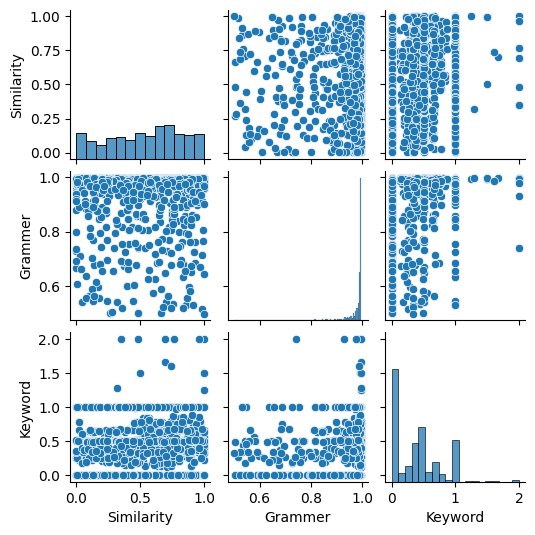

In [38]:
sns.pairplot(df[['Similarity','Grammer','Keyword']], size=1.8)

### Covariance Matrix

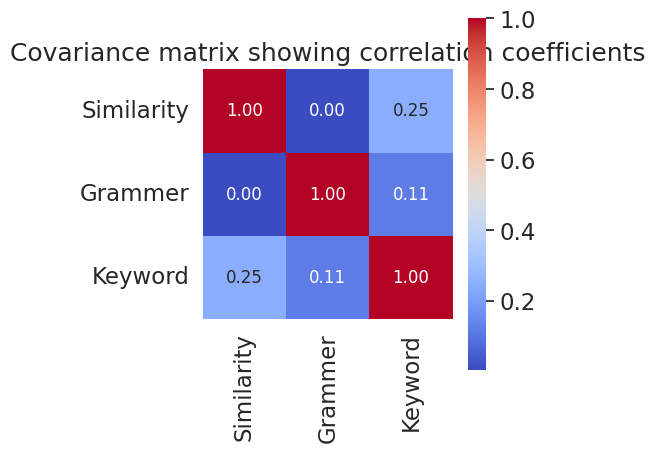

In [39]:
cols = ['Similarity','Grammer','Keyword']
from sklearn.preprocessing import StandardScaler 
stdsc = StandardScaler() 
X_std = stdsc.fit_transform(df[cols].iloc[:,range(0,3)].values)
cov_mat =np.cov(X_std.T)
plt.figure(figsize=(5,5))
sns.set(font_scale=1.5)
hm = sns.heatmap(cov_mat,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 12},
                 cmap='coolwarm',                 
                 yticklabels=cols,
                 xticklabels=cols)
plt.title('Covariance matrix showing correlation coefficients', size = 18)
plt.tight_layout()
plt.show()

# **Regression models**

## Import Libraries

In [75]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier

from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Load Dataset

In [ ]:
def out_of(v):
    global df
    df = pd.read_csv('https://raw.githubusercontent.com/AR13570/MiniProject/main/dataset_with_parameters.csv')
    global x
    x = df[['Similarity','Grammer','Keyword']].values.tolist()
    global y
    global version
    if v==7:
        y = df['Marks'].values.tolist()
        version=7
    if v==3:
        y = df['New Marks'].values.tolist()
        version=3

## Load Dataset (sts)

In [89]:
def out_of(v):
    global df
    df = pd.read_csv('sts_train_with_params.csv')
    global x
    x = df[['Similarity','Grammer','Keyword']].values.tolist()
    global y
    global _y
    global version
    if v==7:
        y = df['Marks'].values.tolist()
        version=7
    if v==3:
        y = df['New Marks'].values.tolist()
        version=3
    if v==5:
        y = df['Marks'].values.tolist()
        version=5
        _y=np.array(y)
        np.round(_y)
        _y=_y.clip(0,version)
        _y=_y.astype(int)

## Confusion Matrix => conf_mat(target,pred)

In [90]:
def conf_matrix(y,pred):
    cm = confusion_matrix(y, pred)
    fig = plt.figure(figsize=(7, 7))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
    ax.set_xlabel('Predicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.tick_bottom()
    ax.set_ylabel('True', fontsize=20)
    plt.yticks(rotation=0)
    plt.show()

## Classification Report func => class_rep(target,output)

In [91]:
def class_rep(y,pred):
    print(classification_report(y, pred))

## Out of 3 version

In [ ]:
out_of(3)

### Linear Regression

In [ ]:
regr = linear_model.LinearRegression()
regr.fit(x, y)

pred=regr.predict(x)
np.ceil(pred)
pred=pred.clip(0,version)
pred=pred.astype(int)

print("MSE:",mean_squared_error(y, pred))

import pickle
# Save the trained model as a pickle string.
pickle.dump(regr,open("LinReg"+str(version)+".pickle",'wb'))

MSE: 0.7596899224806202


#### Confusion Matrix

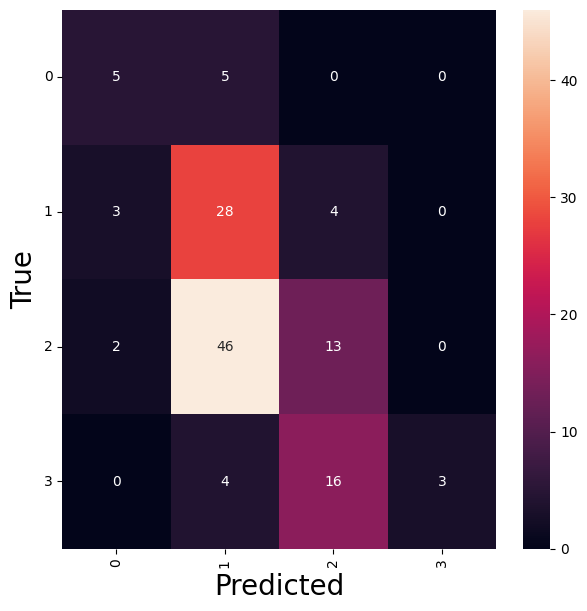

In [ ]:
conf_matrix(y,pred)

#### Classification Report

In [ ]:
class_rep(y,pred)

              precision    recall  f1-score   support

           0       0.50      0.50      0.50        10
           1       0.34      0.80      0.47        35
           2       0.39      0.21      0.28        61
           3       1.00      0.13      0.23        23

    accuracy                           0.38       129
   macro avg       0.56      0.41      0.37       129
weighted avg       0.49      0.38      0.34       129



### Random Forest

#### Regressor

In [ ]:
rf = RandomForestRegressor(n_estimators=150,random_state=4)
rf.fit(x, y)

pred=rf.predict(x)
np.ceil(pred)
pred=pred.clip(0,version)
pred=pred.astype(int)

print(mean_squared_error(y, pred))


#save regressor
pickle.dump(rf,open("RandomForest"+str(version)+".pickle",'wb'))

0.5658914728682171


#### Confusion Matrix

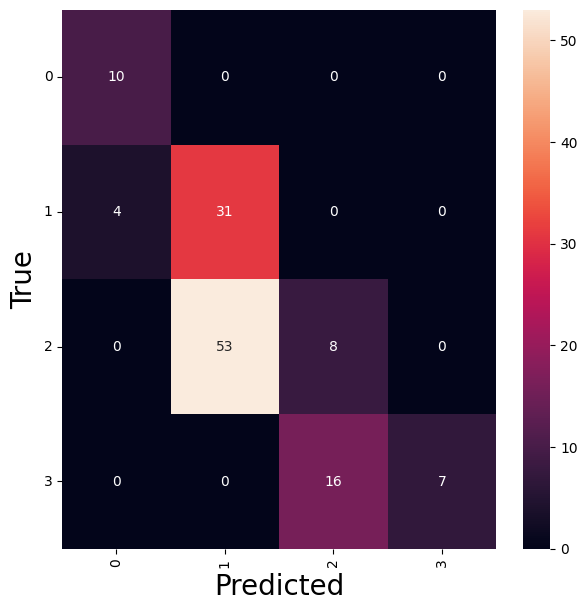

In [ ]:
conf_matrix(y,pred)

#### Classification Report

In [ ]:
class_rep(y,pred)

              precision    recall  f1-score   support

           0       0.71      1.00      0.83        10
           1       0.37      0.89      0.52        35
           2       0.33      0.13      0.19        61
           3       1.00      0.30      0.47        23

    accuracy                           0.43       129
   macro avg       0.60      0.58      0.50       129
weighted avg       0.49      0.43      0.38       129



### XGBoost

#### Regressor

In [ ]:
model = XGBClassifier()
model.fit(x, y)
pred=model.predict(x)
np.ceil(pred)
pred=pred.clip(0,version)
pred=pred.astype(int)
accuracy = round(accuracy_score(y, pred) * 100, 3)
from sklearn.metrics import mean_squared_error

print(mean_squared_error(y, pred))
print(f" Accuracy: {accuracy}%")


#save regressor
pickle.dump(regr,open("XGBoost"+str(version)+".pickle",'wb'))

0.0
 Accuracy: 100.0%


#### Confusion Matrix

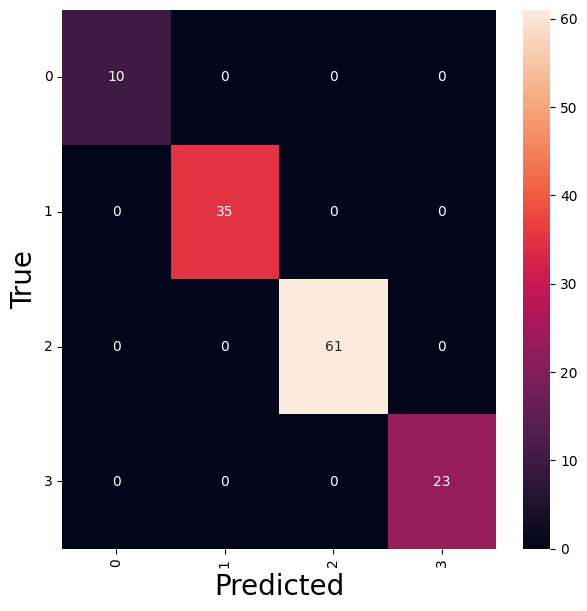

In [ ]:
conf_matrix(y,pred)

#### Classification Report

In [ ]:
class_rep(y,pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        35
           2       1.00      1.00      1.00        61
           3       1.00      1.00      1.00        23

    accuracy                           1.00       129
   macro avg       1.00      1.00      1.00       129
weighted avg       1.00      1.00      1.00       129



## Out of 5 version (stsb dataset)

In [92]:
out_of(5)

### Linear Regression

In [93]:
regr = linear_model.LinearRegression()
regr.fit(x, y)

pred=regr.predict(x)
np.ceil(pred)
pred=pred.clip(0,version)
pred=pred.astype(int)

print("MSE:",mean_squared_error(_y, pred))

import pickle
# Save the trained model as a pickle string.
pickle.dump(regr,open("LinReg"+str(version)+".pickle",'wb'))

MSE: 0.19133762393459733


#### Confusion Matrix

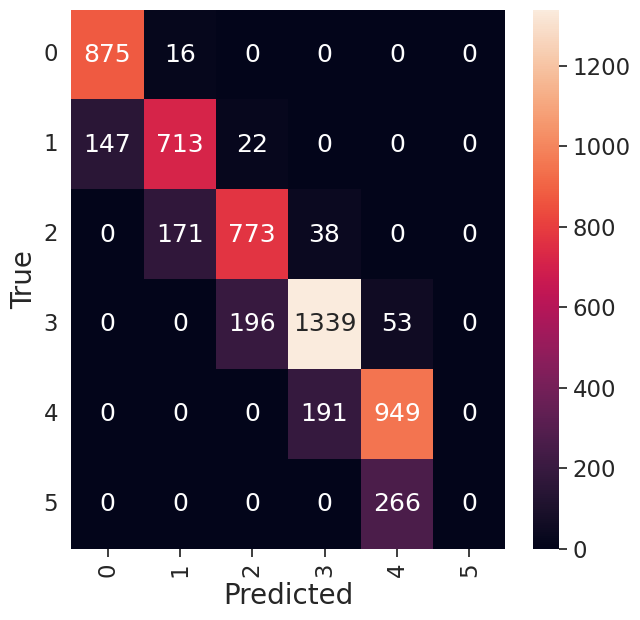

In [94]:
conf_matrix(_y,pred)

#### Classification Report

In [95]:
class_rep(_y,pred)

              precision    recall  f1-score   support

           0       0.86      0.98      0.91       891
           1       0.79      0.81      0.80       882
           2       0.78      0.79      0.78       982
           3       0.85      0.84      0.85      1588
           4       0.75      0.83      0.79      1140
           5       0.00      0.00      0.00       266

    accuracy                           0.81      5749
   macro avg       0.67      0.71      0.69      5749
weighted avg       0.77      0.81      0.79      5749



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Random Forest

#### Regressor

In [96]:
rf = RandomForestRegressor(n_estimators=150,random_state=4)
rf.fit(x, y)

pred=rf.predict(x)
np.ceil(pred)
pred=pred.clip(0,version)
pred=pred.astype(int)

print(mean_squared_error(_y, pred))


#save regressor
pickle.dump(rf,open("RandomForest"+str(version)+".pickle",'wb'))

0.1302835275700122


#### Confusion Matrix

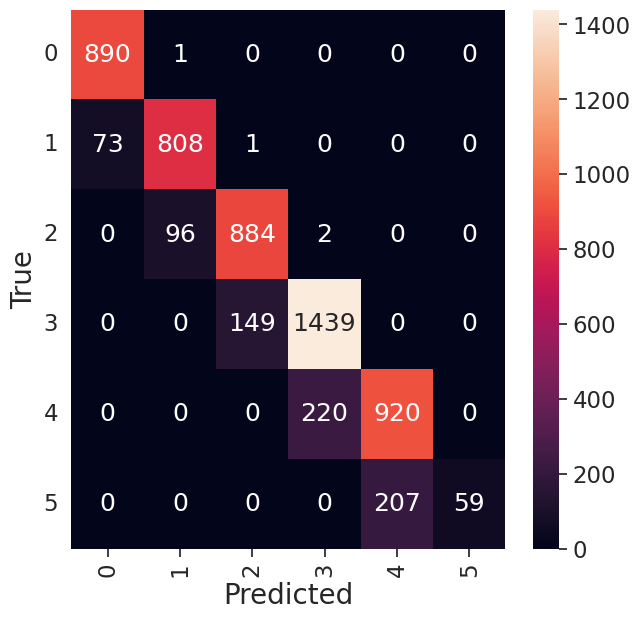

In [97]:
conf_matrix(_y,pred)

#### Classification Report

In [98]:
class_rep(_y,pred)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       891
           1       0.89      0.92      0.90       882
           2       0.85      0.90      0.88       982
           3       0.87      0.91      0.89      1588
           4       0.82      0.81      0.81      1140
           5       1.00      0.22      0.36       266

    accuracy                           0.87      5749
   macro avg       0.89      0.79      0.80      5749
weighted avg       0.87      0.87      0.86      5749



### XGBoost

#### Regressor

In [99]:
model = XGBClassifier()
model.fit(x, _y)
pred=model.predict(x)
np.ceil(pred)
pred=pred.clip(0,version)
pred=pred.astype(int)
accuracy = round(accuracy_score(_y, pred) * 100, 3)
from sklearn.metrics import mean_squared_error

print(mean_squared_error(_y, pred))
print(f" Accuracy: {accuracy}%")


#save regressor
pickle.dump(regr,open("XGBoost"+str(version)+".pickle",'wb'))

0.0066098451904679075
 Accuracy: 99.339%


#### Confusion Matrix

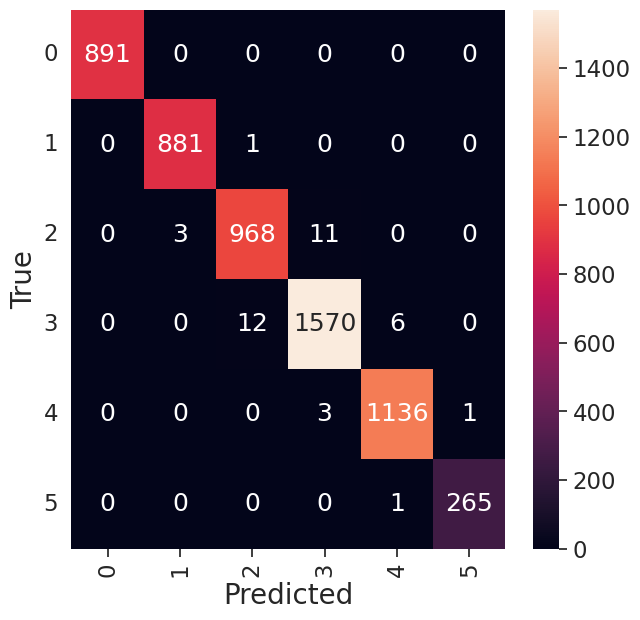

In [100]:
conf_matrix(_y,pred)

#### Classification Report

In [101]:
class_rep(_y,pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       891
           1       1.00      1.00      1.00       882
           2       0.99      0.99      0.99       982
           3       0.99      0.99      0.99      1588
           4       0.99      1.00      1.00      1140
           5       1.00      1.00      1.00       266

    accuracy                           0.99      5749
   macro avg       0.99      0.99      0.99      5749
weighted avg       0.99      0.99      0.99      5749



## Out of 7 version

In [ ]:
out_of(7)

### Linear Regression

In [ ]:
regr = linear_model.LinearRegression()
regr.fit(x, y)

pred=regr.predict(x)
np.ceil(pred)
pred=pred.clip(0,version)
pred=pred.astype(int)

print("MSE:",mean_squared_error(y, pred))

import pickle
# Save the trained model as a pickle string.
pickle.dump(regr,open("LinReg"+str(version)+".pickle",'wb'))

MSE: 2.046511627906977


#### Confusion Matrix

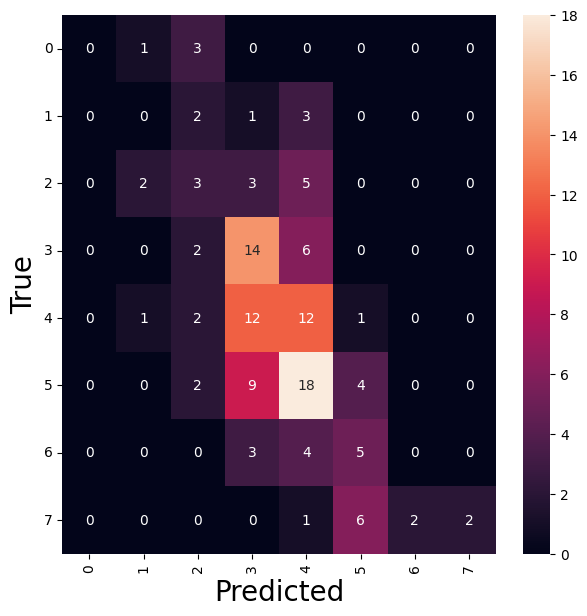

In [ ]:
conf_matrix(y,pred)

#### Classification Report

In [ ]:
class_rep(y,pred)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         6
           2       0.21      0.23      0.22        13
           3       0.33      0.64      0.44        22
           4       0.24      0.43      0.31        28
           5       0.25      0.12      0.16        33
           6       0.00      0.00      0.00        12
           7       1.00      0.18      0.31        11

    accuracy                           0.27       129
   macro avg       0.26      0.20      0.18       129
weighted avg       0.28      0.27      0.23       129



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Random Forest

#### Regressor

In [ ]:
rf = RandomForestRegressor(n_estimators=150,random_state=4)
rf.fit(x, y)

pred=rf.predict(x)
np.ceil(pred)
pred=pred.clip(0,version)
pred=pred.astype(int)

print(mean_squared_error(y, pred))


#save regressor
pickle.dump(rf,open("RandomForest"+str(version)+".pickle",'wb'))

0.6666666666666666


#### Confusion Matrix

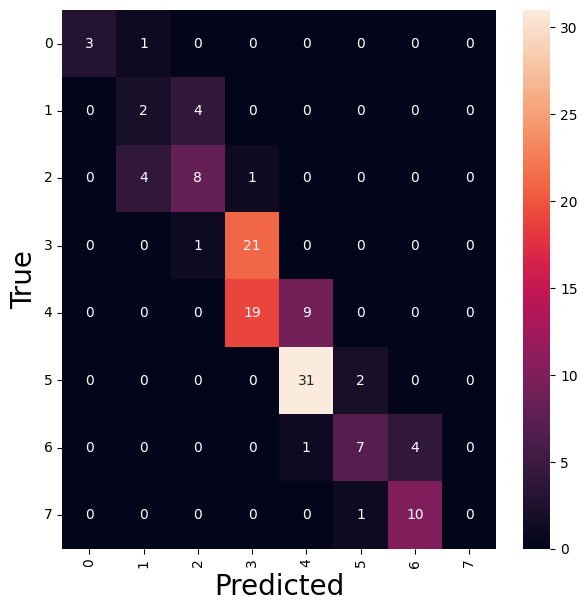

In [ ]:
conf_matrix(y,pred)

#### Classification Report

In [ ]:
class_rep(y,pred)

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.29      0.33      0.31         6
           2       0.62      0.62      0.62        13
           3       0.51      0.95      0.67        22
           4       0.22      0.32      0.26        28
           5       0.20      0.06      0.09        33
           6       0.29      0.33      0.31        12
           7       0.00      0.00      0.00        11

    accuracy                           0.38       129
   macro avg       0.39      0.42      0.39       129
weighted avg       0.32      0.38      0.33       129



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### XGBoost

#### Regressor

In [ ]:
model = XGBClassifier()
model.fit(x, y)
pred=model.predict(x)
np.ceil(pred)
pred=pred.clip(0,version)
pred=pred.astype(int)
accuracy = round(accuracy_score(y, pred) * 100, 3)
from sklearn.metrics import mean_squared_error

print(mean_squared_error(y, pred))
print(f" Accuracy: {accuracy}%")


#save regressor
pickle.dump(regr,open("XGBoost"+str(version)+".pickle",'wb'))

0.0
 Accuracy: 100.0%


#### Confusion Matrix

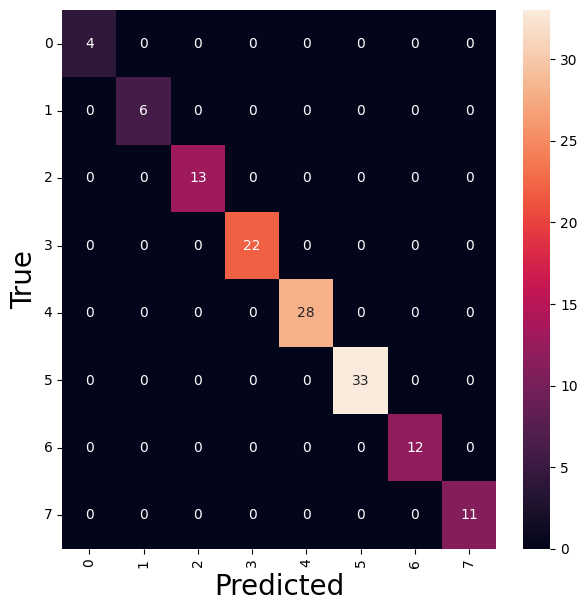

In [ ]:
conf_matrix(y,pred)

#### Classification Report

In [ ]:
class_rep(y,pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00        22
           4       1.00      1.00      1.00        28
           5       1.00      1.00      1.00        33
           6       1.00      1.00      1.00        12
           7       1.00      1.00      1.00        11

    accuracy                           1.00       129
   macro avg       1.00      1.00      1.00       129
weighted avg       1.00      1.00      1.00       129



## Out of 7 converted to 3

In [ ]:
out_of(7)
_y=df['New Marks'].values.tolist()

### Linear Regression

In [ ]:
regr = linear_model.LinearRegression()
regr.fit(x, y)

pred=regr.predict(x)
np.ceil(pred)
pred=pred.clip(0,version)
pred=(pred/7)*3
pred=pred.astype(int)

print("MSE:",mean_squared_error(_y, pred))

MSE: 0.8062015503875969


#### Confusion Matrix

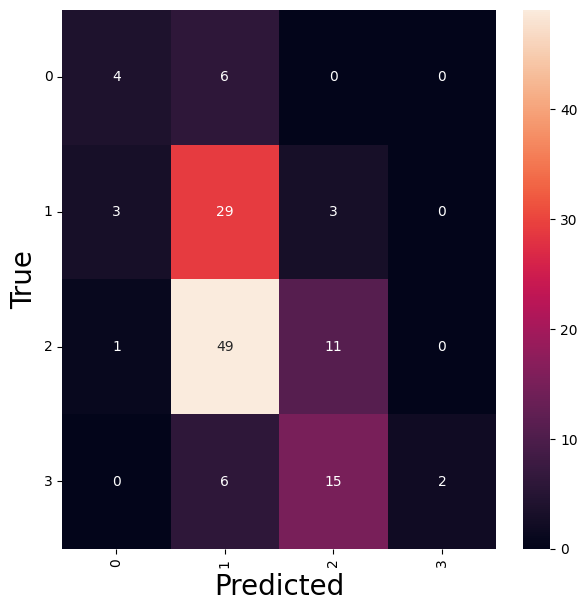

In [ ]:
conf_matrix(_y,pred)

#### Classification Report

In [ ]:
class_rep(_y,pred)

              precision    recall  f1-score   support

           0       0.50      0.40      0.44        10
           1       0.32      0.83      0.46        35
           2       0.38      0.18      0.24        61
           3       1.00      0.09      0.16        23

    accuracy                           0.36       129
   macro avg       0.55      0.37      0.33       129
weighted avg       0.48      0.36      0.30       129



### Random Forest

#### Regressor

In [ ]:
rf = RandomForestRegressor(n_estimators=150,random_state=4)
rf.fit(x, y)

pred=rf.predict(x)
np.ceil(pred)
pred=pred.clip(0,version)
pred=(pred/7)*3
pred=pred.astype(int)

print("MSE:",mean_squared_error(_y, pred))

MSE: 0.5581395348837209


#### Confusion Matrix

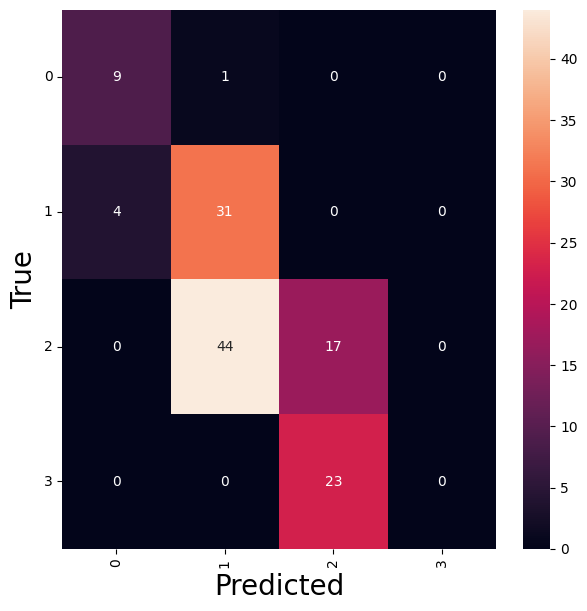

In [ ]:
conf_matrix(_y,pred)

#### Classification Report

In [ ]:
class_rep(_y,pred)

              precision    recall  f1-score   support

           0       0.69      0.90      0.78        10
           1       0.41      0.89      0.56        35
           2       0.42      0.28      0.34        61
           3       0.00      0.00      0.00        23

    accuracy                           0.44       129
   macro avg       0.38      0.52      0.42       129
weighted avg       0.37      0.44      0.37       129



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### XGBoost

#### Regressor

In [ ]:
model = XGBClassifier()
model.fit(x, y)
pred=model.predict(x)
np.ceil(pred)
pred=pred.clip(0,version)
pred=(pred/7)*3
pred=pred.astype(int)
accuracy = round(accuracy_score(_y, pred) * 100, 3)

print("MSE:",mean_squared_error(_y, pred))
print(f" Accuracy: {accuracy}%")

MSE: 0.4108527131782946
 Accuracy: 58.915%


#### Confusion Matrix

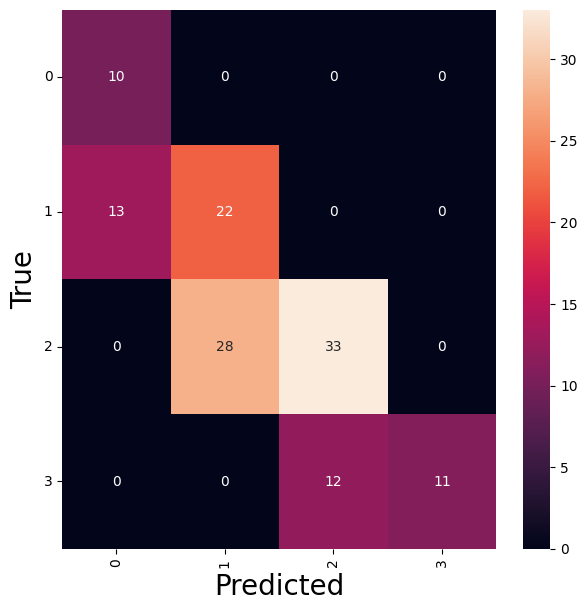

In [ ]:
conf_matrix(_y,pred)

#### Classification Report

In [ ]:
class_rep(_y,pred)

              precision    recall  f1-score   support

           0       0.43      1.00      0.61        10
           1       0.44      0.63      0.52        35
           2       0.73      0.54      0.62        61
           3       1.00      0.48      0.65        23

    accuracy                           0.59       129
   macro avg       0.65      0.66      0.60       129
weighted avg       0.68      0.59      0.60       129



# **Using Regression Model from saved file**

In [ ]:
import pickle
import numpy as np

def finalMarks(li):
    out_of = 7

    regressor={"lr7":"LinReg7.pickle","rf7":"RandomForest7.pickle","xgb7":"XGBoost7.pickle",
           "lr3":"LinReg3.pickle","rf3":"RandomForest3.pickle","xgb3":"XGBoost7.pickle"}
    loaded_model = pickle.load(open(regressor['lr'+str(out_of)],'rb')) 
    x=loaded_model.predict(li)
    np.floor(x)
    x=x.clip(0,out_of)
    x=int(x)
    print(x,f"out of {out_of}")
    return x

In [ ]:
finalMarks([[1,1,1]])

3 out of 3


3

## Testing Dataset

### Out of 5 version (stsb dataset)

In [65]:
import pickle
import numpy as np
out_of(5)
regressor={"lr7":"LinReg7.pickle","rf7":"RandomForest7.pickle","xgb7":"XGBoost7.pickle",
           "lr5":"LinReg5.pickle","rf5":"RandomForest5.pickle","xgb5":"XGBoost5.pickle",
           "lr3":"LinReg3.pickle","rf3":"RandomForest3.pickle","xgb3":"XGBoost7.pickle"}

### Linear Regression

In [66]:
regr = pickle.load(open(regressor['lr'+str(version)],'rb'))

pred=regr.predict(x)
np.ceil(pred)
pred=pred.clip(0,version)
pred=pred.astype(int)

print("MSE:",mean_squared_error(_y, pred))


MSE: 0.6040609137055838


#### Confusion Matrix

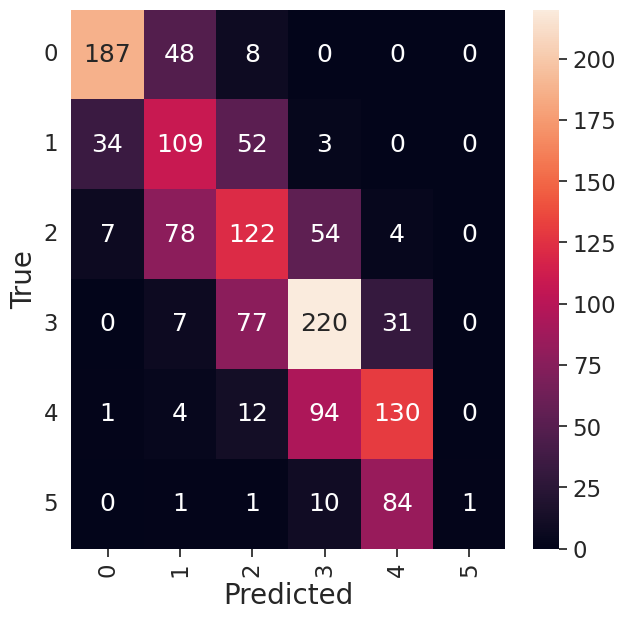

In [67]:
conf_matrix(_y,pred)

#### Classification Report

In [68]:
class_rep(_y,pred)

              precision    recall  f1-score   support

           0       0.82      0.77      0.79       243
           1       0.44      0.55      0.49       198
           2       0.45      0.46      0.45       265
           3       0.58      0.66      0.61       335
           4       0.52      0.54      0.53       241
           5       1.00      0.01      0.02        97

    accuracy                           0.56      1379
   macro avg       0.63      0.50      0.48      1379
weighted avg       0.60      0.56      0.54      1379



### Random Forest

#### Regressor

In [69]:
rf = pickle.load(open(regressor['rf'+str(version)],'rb'))

pred=rf.predict(x)
np.ceil(pred)
pred=pred.clip(0,version)
pred=pred.astype(int)

print(mean_squared_error(_y, pred))


0.5953589557650472


#### Confusion Matrix

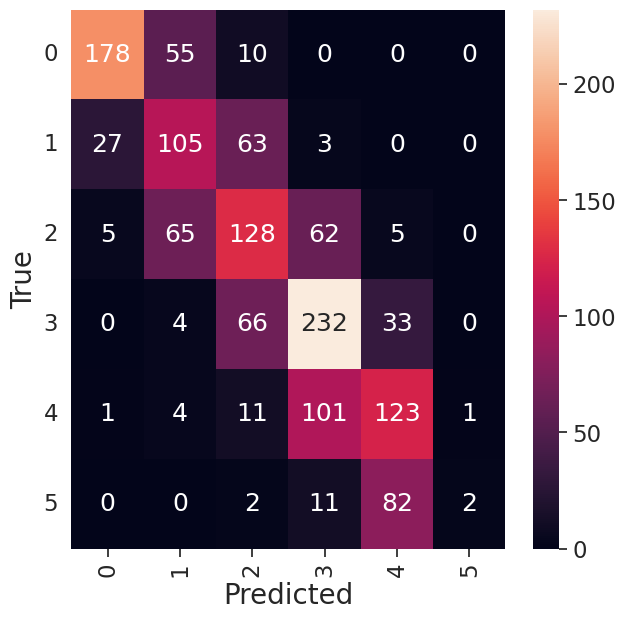

In [70]:
conf_matrix(_y,pred)

#### Classification Report

In [71]:
class_rep(_y,pred)

              precision    recall  f1-score   support

           0       0.84      0.73      0.78       243
           1       0.45      0.53      0.49       198
           2       0.46      0.48      0.47       265
           3       0.57      0.69      0.62       335
           4       0.51      0.51      0.51       241
           5       0.67      0.02      0.04        97

    accuracy                           0.56      1379
   macro avg       0.58      0.49      0.49      1379
weighted avg       0.57      0.56      0.54      1379



### XGBoost

#### Regressor

In [72]:
model = pickle.load(open(regressor['xgb'+str(version)],'rb'))

pred=model.predict(x)
np.ceil(pred)
pred=pred.clip(0,version)
pred=pred.astype(int)
accuracy = round(accuracy_score(_y, pred) * 100, 3)
from sklearn.metrics import mean_squared_error

print(mean_squared_error(_y, pred))
print(f" Accuracy: {accuracy}%")


#save regressor
pickle.dump(regr,open("XGBoost"+str(version)+".pickle",'wb'))

0.6040609137055838
 Accuracy: 55.765%


#### Confusion Matrix

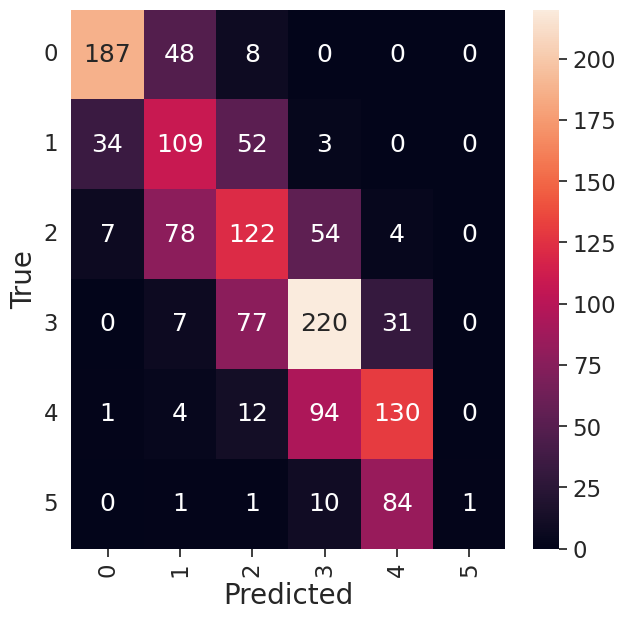

In [73]:
conf_matrix(_y,pred)

#### Classification Report

In [74]:
class_rep(_y,pred)

              precision    recall  f1-score   support

           0       0.82      0.77      0.79       243
           1       0.44      0.55      0.49       198
           2       0.45      0.46      0.45       265
           3       0.58      0.66      0.61       335
           4       0.52      0.54      0.53       241
           5       1.00      0.01      0.02        97

    accuracy                           0.56      1379
   macro avg       0.63      0.50      0.48      1379
weighted avg       0.60      0.56      0.54      1379

